Importing all the libraries.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Random seed for reproducibility

In [16]:
np.random.seed(42)

Load the data. Opens dialouge box to locally upload the data. (later will figure enter directly)

In [17]:
import pandas as pd
from google.colab import files
import io

def load_data():
    # Upload the file
    uploaded = files.upload()  # Prompts file upload dialog

    # Get the uploaded filename
    filename = list(uploaded.keys())[0]

    # Read the CSV data
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

    # Display basic information
    print(f"Dataset shape: {df.shape}")
    return df

# Call the function to load data
df = load_data()


Saving data.csv to data (2).csv
Dataset shape: (199, 18)


Data exploration and preparation


In [18]:
def explore_data(df):
    # Display basic information about the dataset
    print("\nData Information:")
    print(df.info())

    # Display descriptive statistics
    print("\nDescriptive Statistics:")
    print(df.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df
df = explore_data(df)


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           199 non-null    object 
 1   price          199 non-null    float64
 2   bedrooms       199 non-null    float64
 3   bathrooms      199 non-null    float64
 4   sqft_living    199 non-null    int64  
 5   sqft_lot       199 non-null    int64  
 6   floors         199 non-null    float64
 7   waterfront     199 non-null    int64  
 8   view           199 non-null    int64  
 9   condition      199 non-null    int64  
 10  sqft_above     199 non-null    int64  
 11  sqft_basement  199 non-null    int64  
 12  yr_built       199 non-null    int64  
 13  yr_renovated   199 non-null    int64  
 14  street         199 non-null    object 
 15  city           199 non-null    object 
 16  statezip       199 non-null    object 
 17  country        199 non-null    obje

Visualize feature relationships

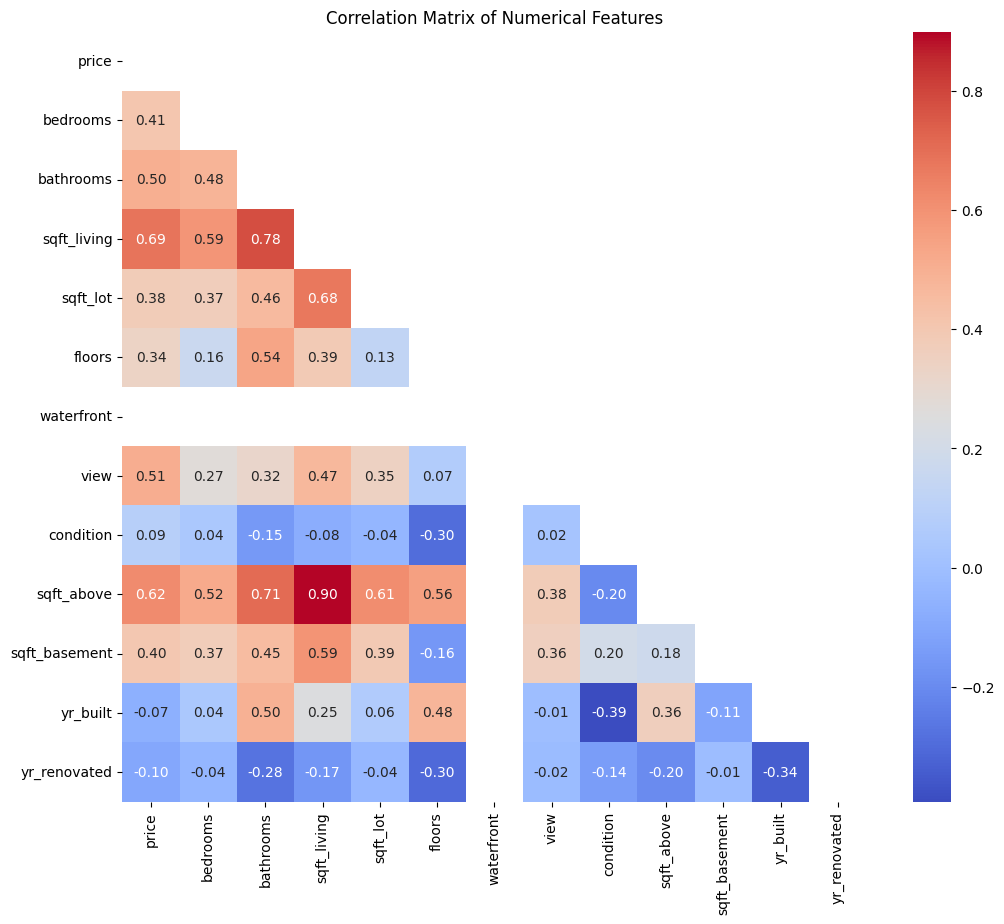

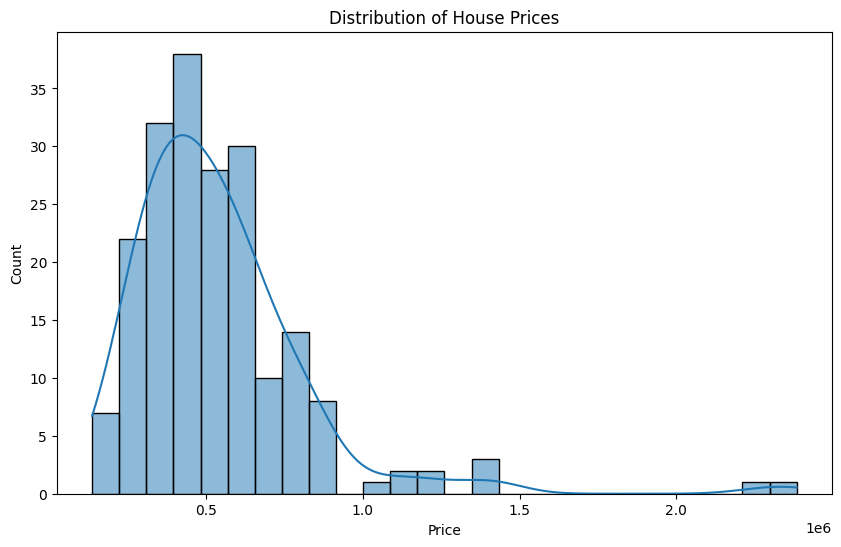

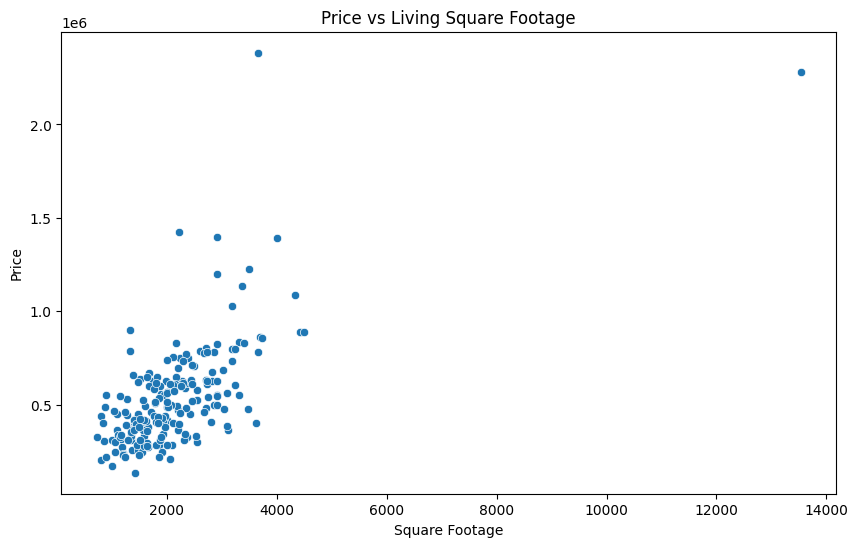

In [19]:
def visualize_data(df):
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Plot correlation matrix
    corr = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    # Plot price distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True)
    plt.title('Distribution of House Prices')
    plt.xlabel('Price')
    plt.show()

    # Plot relationship between square footage and price
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='sqft_living', y='price', data=df)
    plt.title('Price vs Living Square Footage')
    plt.xlabel('Square Footage')
    plt.ylabel('Price')
    plt.show()

visualize_data(df)


Data Preprocessing

In [21]:
def preprocess_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract year and month as new features
    df['sale_year'] = df['date'].dt.year
    df['sale_month'] = df['date'].dt.month

    # Calculate house age at time of sale
    df['house_age'] = df['sale_year'] - df['yr_built']

    # Create a renovation indicator
    df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)

    # Time since renovation (if any)
    df['years_since_renovation'] = df['sale_year'] - df['yr_renovated']
    # Replace years_since_renovation with 0 where the house was not renovated (yr_renovated was 0)
    # The original code attempted to replace the value equal to 'sale_year' with 0.
    # This happens when yr_renovated is 0.
    df.loc[df['yr_renovated'] == 0, 'years_since_renovation'] = 0

    # Create a feature for total square footage
    df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

    # Create price per square foot
    # Handle potential division by zero if sqft_living is 0
    df['price_per_sqft'] = df['price'] / df['sqft_living'].replace(0, np.nan)


    # Select relevant features for modeling
    features = [
        'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'house_age',
        'was_renovated', 'total_sqft'
    ]

    # Select columns to use for modeling
    X = df[features]
    y = df['price']

    return X, y

X, y = preprocess_data(df)

Build and train the model

Training set size: (159, 11)
Testing set size: (40, 11)

Model Evaluation:
Mean Squared Error: 23137214641.60
Root Mean Squared Error: 152109.22
R² Score: 0.4879

Feature Importance:
          Feature   Coefficient
2     sqft_living  2.119322e+05
8       house_age  1.000060e+05
4          floors  8.175076e+04
6            view  6.462126e+04
3        sqft_lot -3.144049e+04
7       condition  2.516584e+04
10     total_sqft -2.286831e+04
9   was_renovated -7.610691e+03
0        bedrooms -5.863954e+03
1       bathrooms -6.824416e+02
5      waterfront -1.455192e-11


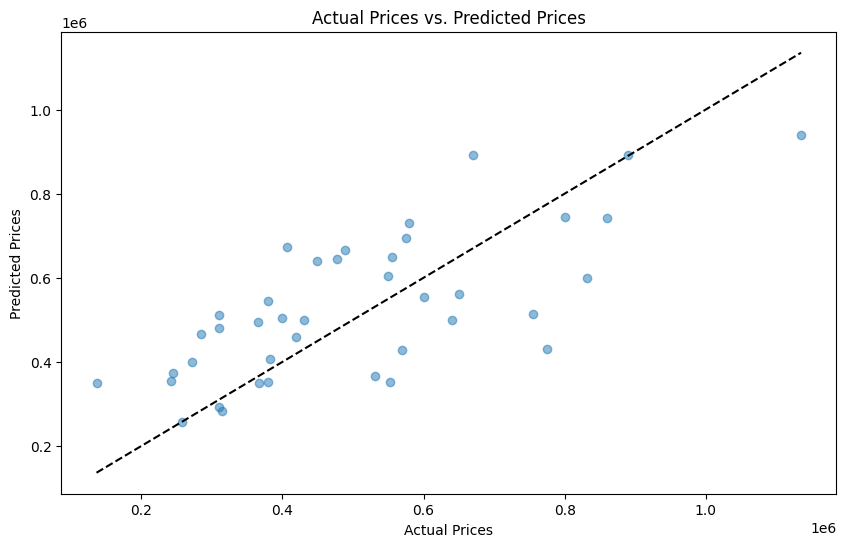

In [23]:
def build_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Initialize the model
    model = LinearRegression()

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Evaluation:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Analyze feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual Prices vs. Predicted Prices')

    # Add the perfect prediction line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.show()

    return model, scaler, X_train, X_test, y_train, y_test

# Build and evaluate model
model, scaler, X_train, X_test, y_train, y_test = build_model(X, y)

Sample Prediction

In [25]:
#sample_prediction
sample_house = X_test.iloc[0].values.reshape(1, -1)
sample_house_scaled = scaler.transform(sample_house)
predicted_price = model.predict(sample_house_scaled)[0]
actual_price = y_test.iloc[0]

print("\nSample Prediction:")
print(f"Actual Price: ${actual_price:.2f}")
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Difference: ${abs(actual_price - predicted_price):.2f}")



Sample Prediction:
Actual Price: $580000.00
Predicted Price: $729163.04
Difference: $149163.04
